Bella is a translational neuroscientist who evaluates the changes to cognitive processes in a mouse disease model for schizophrenia. She noted that PV gene expression is reduced in this model and wonders what possible effects there could be on the mesoconnectome and the resulting brain activity (modeled through the virtual mouse brain on the HBP platform). She uses the weight matrix of the latest predictive model on a gene expression vector that includes a reduction in PV expression and predicts the new connectivity patterns and sends them to the virtual mouse brain, whose output is analyzed through the neural activity tool (NAR).


The cfg.py file is used for updating and importing all useful libraries to be used throughout the analysis.
Moreover, all functions/classes inside cfg.py (find_notebook, NotebookLoader, NotebookFinder) were taken from a tutorial on how to import external jupyter notebooks as modules.  
Documentations about the aforementioned functions and classes can be found in this link:  
https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html  
The code below is responsible for downloading the aforementioned data from the storage space.  

In [1]:
from cfg import *

/home/ntimonidis/Brain-Connectivity Project/25 3 2019


In this step a series of libraries whose classes and functions have to be utilized throughout the analysis,  
are being downloaded from the storage space and imported as modules.

In [26]:
import PrimaryLibrary as PL
imp.reload(PL)
clear_output()

In this cell, an initialization of an sbaInterface_class instance is being made.
The sbaInterface_class serves as an API for calling the Scalable Brain Composer (SBA)  brain visualization tool. As shown by the steps below, we will use the SBA for a series of visualizations.  
As soon as the initialization is being made, a window will pop-up. On later steps, values will be passed to SBA which will lead to visualizations displayed in the aforementioned window.

### Data/Parameter Intialization
We load the gene expression dataset that we have used for our predictive analysis (CCP Pipeline).

In [27]:
GeneExp        = h5py.File('G_Exp.hdf5', 'r')['dataset1']
GeneMeta       = pk.load(open('GeneMeta.pkl','r'))
ConDict        = pk.load(open('CreLineDict.pkl','rb'))
clear_output()

Before the analysis initiation, the gene expression dataset is being pre-processed with the PreProcessing function of the Mesoconnectome Predictor (MesoPred instance of our model).

In [28]:
MesoPred                = PL.MesoconnectomePredictor()

In [5]:
ClfResults_ridge = {}; 

for key in MesoPred.ConDict.keys():
    if os.path.isfile('saves/' + key + '_all_results' + '_ridge.pkl') == True:
        infile = 'saves/' + key + '_all_results' + '_ridge.pkl'
        print infile
        tmp = pk.load(open(infile,'r'))
        ClfResults_ridge[key] = {key:val for key,val in tmp.items() }
         
clear_output()      

Once the MesoPred instance has been initialized, we reduce our gene expression data to a set of structural brain areas that have the finest possible level of description (leaf keys).    

In [29]:
GeneExp_reduced         = np.asarray(GeneExp)[MesoPred.params['leaf_keys'],:]
ConDict_reduced         = np.asarray(ConDict['wild_type']['ConMat'])[MesoPred.params['leaf_keys'],:]

The pre-processing function cleans the dataset from NaN (not a number) values and outliers, performs cubic root transformation to achieve a less skewed distribution, and z-scores the data for faster algorithmic convergence.  

In [30]:
GeneExp_new, scaler,b,c     = MesoPred.PreProcessing(GeneExp_reduced, MesoPred.params,ConDict_reduced)
#GeneExp_new, scaler    = MesoPred.PreProcessing(GeneExp_reduced, MesoPred.params)
clear_output()

Since we are not interested in training a predictive model but instead testing the data on pre-existing ones, the data are being re-scaled with a scaler object back to their pre-scaled form.

In [8]:
GeneExp_res             = scaler.inverse_transform(GeneExp_new)

### Step 1: Transcriptional Gradients
Transcriptional gradients from the given gene expression data are being initially estimated with the Dictionary learning and sparse coding technique (DLSC) (J. Mairal, F. Bach, J. Ponce, and G. Sapiro. Online dictionary learning for sparse coding. ICML, 2009).  
The estimation is being done in order for Bella to assess the effect that the gene co-expression network of PV has on anatomically distinct structural brain areas.

Since the process takes quite some time, the results have been stored in pickle files and are loaded for our analysis. However, the commented code indicates the way that we call the dictionary learning function.

In [8]:
#Components, Code, dict_mdl = MesoPred.DictionaryDecomposition(GeneExp_res, n_comp = 200)
#pk.dump(Components, open('saves/Components.pkl','wb'))
#pk.dump(Code, open('saves/Code.pkl','wb'))
#pk.dump(dict_mdl, open('saves/dict_mdl.pkl','wb'))
Components  = pk.load(open('saves/Components.pkl','rb'))
Code = pk.load(open('saves/Code.pkl','rb'))
dict_mdl   = pk.load(open('saves/dict_mdl.pkl','rb'))

### Step 2:  Gradient selection
In this step, Bella can identify the gradient in which the PV gene is most strongly co-expressed for further analysis.

In [9]:
PV_index = [idx for idx,gene in enumerate(MesoPred.params['Gene Acronyms']) if 'Pvalb' in gene][0]
PV_dominated_atom = np.argmax(Components[:,PV_index])
print 'The selected PV-related gradient is: {}.\nThe co-expression energy is: {}'.format(PV_dominated_atom, np.max(Components[:,PV_index]))

The selected PV-related gradient is: 58.
The co-expression energy is: 0.0382031943086


### Step 3: Gradient visualization  
In this step, the effect of the selected gradient across the mouse brain is being visually inspected with three different approaches:
*  Brain slice visualization with the use of the BrainPlotter tool.
*  3D brain visualization with the use of the Scalable Brain Composer (SBA) tool.
*  Cortical flatmap visualization the use of the BrainPlotter tool.

#### Brain Slice visualization

In [10]:
top_50_vals  = np.argsort(Components[PV_dominated_atom,:])[::-1] 
top_50_genes = [idx for idx, val in enumerate(top_50_vals) if 'Pvalb' in MesoPred.params['Gene Acronyms'][val]]
print Components[PV_dominated_atom,PV_index]

0.0382031943086


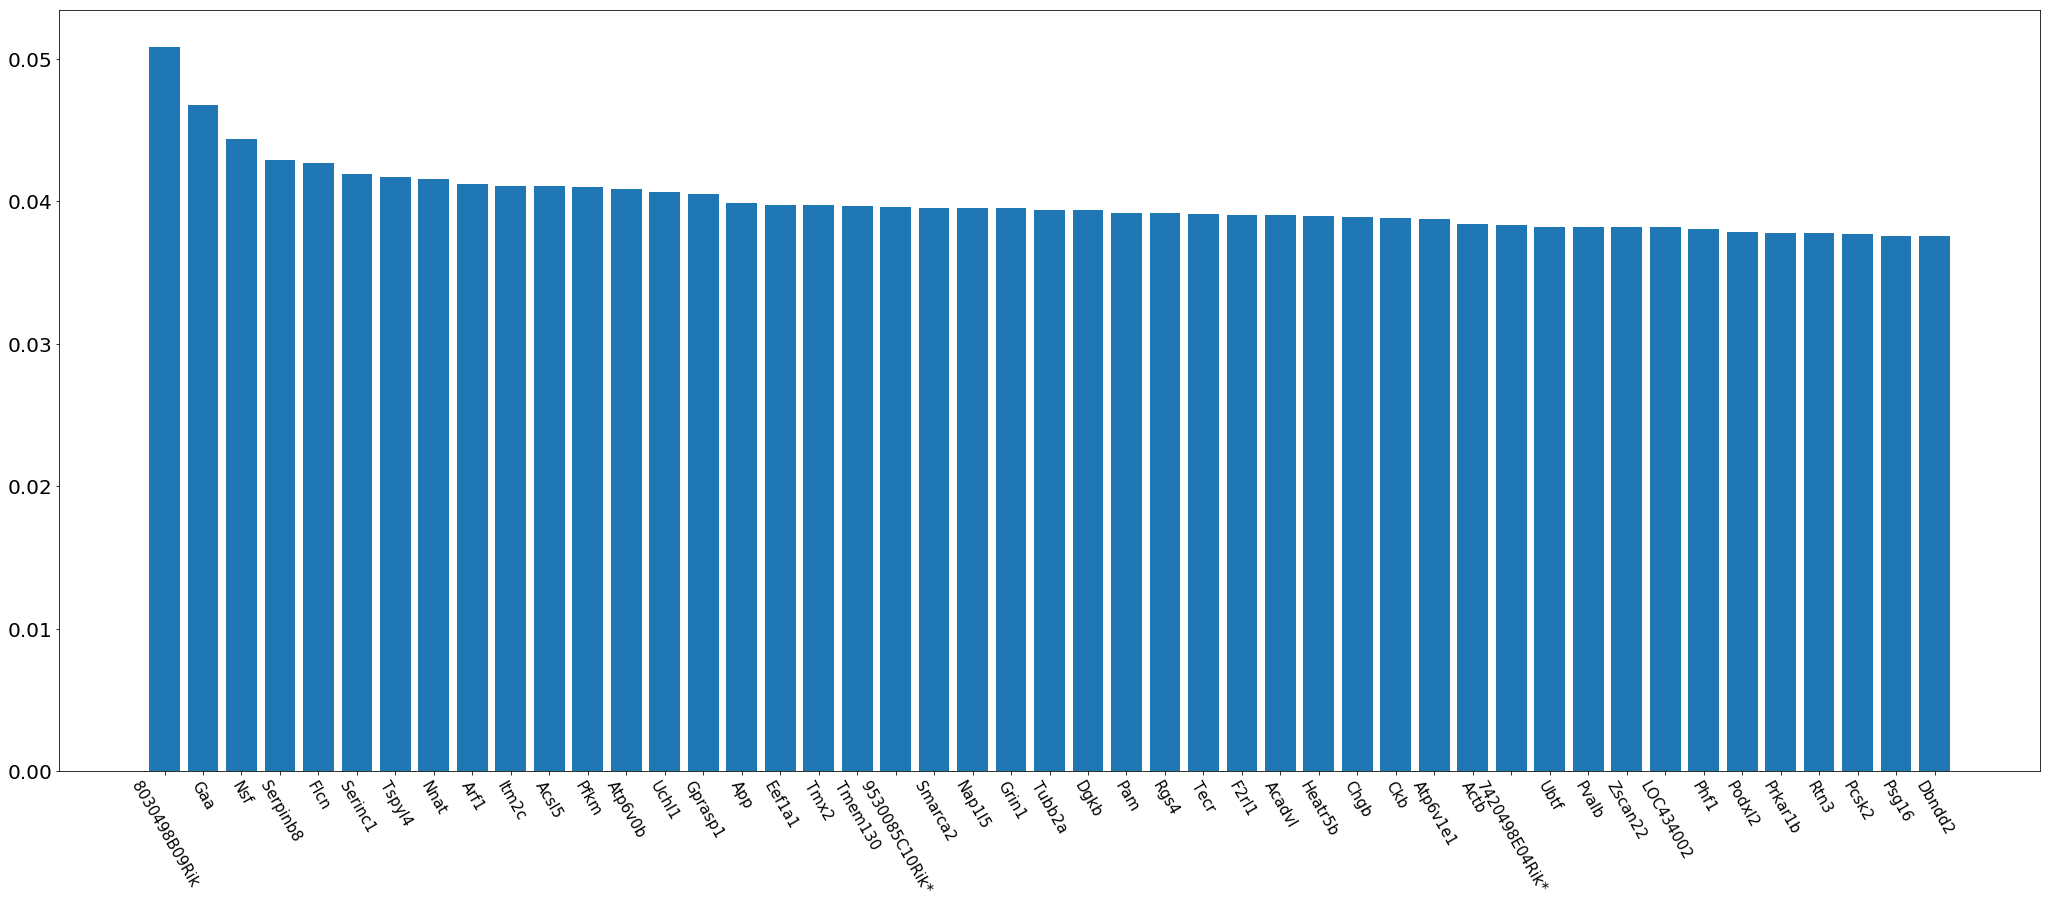

In [97]:
top_50_vals  = np.argsort(Components[PV_dominated_atom,:])[::-1][0:50]
top_50_genes = [MesoPred.params['Gene Acronyms'][val] for val in top_50_vals]
top_50_ids = [MesoPred.params['Gene Ids'][val] for val in top_50_vals]
#pk.dump([top_50_genes, Components, PV_dominated_atom, top_50_vals], open('paper1_figures/elements_for_PV_module_before.pkl','wb'))

#[top_50_genes, Components, PV_dominated_atom, top_50_vals] = pk.load(open('paper1_figures/elements_for_PV_module_before.pkl','rb'))
plt.figure(figsize = (12,8))
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(35.5, 14, forward=True)
plt.bar(top_50_genes, Components[PV_dominated_atom, top_50_vals])
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize = 15)
ax.yaxis.set_tick_params(labelsize = 20)
plt.xticks(rotation = 300)
plt.savefig('paper1_figures/top_30_genes_before_module_{}.jpg'.format(PV_dominated_atom))
plt.savefig('paper1_figures/top_30_genes_before_module_{}.eps'.format(PV_dominated_atom))
plt.show()


In [50]:
top_50_ids = [MesoPred.params['Gene Ids'][val] for val in top_50_vals]
top_50_ids_ref = [val for val in top_50_ids if val is not None]
post_syn_hits = MesoPred.GOenrichment(top_50_ids_ref)

> <string>(61)GOenrichment()

ipdb> continue


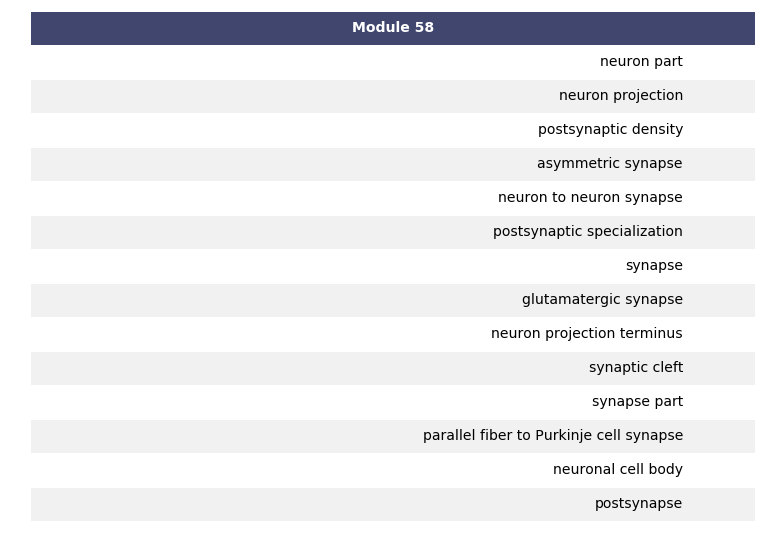

In [52]:
GODict = {'Module {}'.format(PV_dominated_atom) : post_syn_hits}
GO_DF = pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in GODict.items()]))
#pk.dump(GO_DF, open('paper1_figures/ontology_for_module_58.pkl','wb'))

#GO_DF = pk.load(open('paper1_figures/ontology_for_module_58.pkl','rb'))
tbl = PL.render_mpl_table(GO_DF)
plt.savefig('paper1_figures/ontology_results_of_module_{}.jpg')

PrimaryLibrary.ipynb:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  {


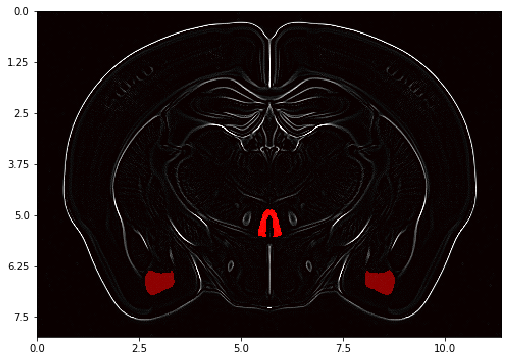

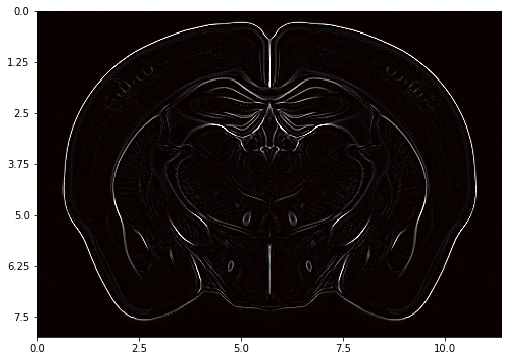

In [13]:
BP_25 = PL.BrainPlotter(resolution = 25)
BP_25.fit(projection = Code[:,PV_dominated_atom], 
          chosen_indices = MesoPred.params['remaining_indices'])
#pk.dump(BP_25, open('paper1_figures/gene_modules/PV_module_BP_25.pkl','wb'))

#BP_25 = pk.load(open('paper1_figures/gene_modules/PV_module_BP_25.pkl','rb'))
BP_25.plot_slice(savefile = 'paper1_figures/gene_module_slice {}.jpg'.format(PV_dominated_atom))

#### Call to the SBA tool   
When SBA is being called, a green pop-up window will show up. If the user clicks on "Re-open SBA Composer" the results will be displayed on the window that was opened during the first steps.   
The user can navigate through the various parts of the mouse brain for visual inspection, by utilizing the buttons on the right part of the screen.  
A tutorial for the tool is being provided by clicking at the Readme & FAQ button at the left top of the screen. 

#### Cortical flatmap visualization

PrimaryLibrary.ipynb:45: RuntimeWarning: invalid value encountered in divide
  "metadata": {},


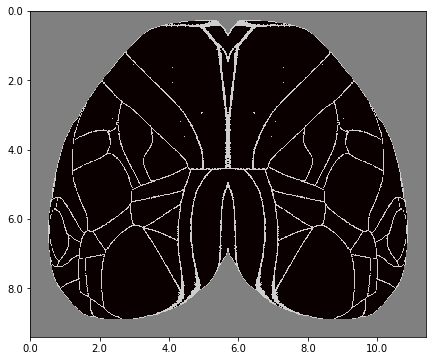

In [18]:
BP_10 = PL.BrainPlotter(resolution = 10)
BP_10.fit(projection = Code[:,PV_dominated_atom], 
          chosen_indices = MesoPred.params['remaining_indices'])
#pk.dump(BP_10, open('paper1_figures/gene_modules/PV_module_BP_10.pkl','wb'))

#BP_10 = pk.load(open('paper1_figures/gene_modules/PV_module_BP_10.pkl','rb'))
BP_10.plot_flatmap(savefile = 'paper1_figures/gene_module_flatmap {}.jpg'.format(PV_dominated_atom))

### Step 4: Modification of PV related expression
In this step, Bella can modify the expression of PV in a way of simulating the reduced values that she had found in her model.
The relationship between modified PV and the dominant gradient can be shown in two ways:
1.  Expression of PV is being reduced
2.  The gene coefficients corresponding to the dominant gradient are being reduced, and the gene expression is being re-estimated based on the inner product between the new coefficients and the gradients.    


In this analysis we shall focus on the first case

#### Case 1

#### Case 2

In [11]:
Components_mod  = Components.copy()
Components_mod[PV_dominated_atom,:]*=10e-3
Code_mod  = Code.copy()
Code_mod[:,PV_dominated_atom]*=10e-3
GeneExp_mod2 = np.dot(Code_mod,Components)
GeneExp_mod = np.dot(Code,Components)

In [ ]:
BP_25 = PL.BrainPlotter(resolution = 25)
BP_25.fit(projection = Code[:,PV_dominated_atom], 
          chosen_indices = MesoPred.params['remaining_indices'],
          projection2 = Code_mod[:,PV_dominated_atom])
#pk.dump(BP_25, open('paper1_figures/gene_modules/PV_module_BP_25.pkl','wb'))

#BP_25 = pk.load(open('paper1_figures/gene_modules/PV_module_BP_25.pkl','rb'))
BP_25.plot_slice(savefile = 'paper1_figures/gene_module_slice {}.jpg'.format(PV_dominated_atom))

In [ ]:
BP_10 = PL.BrainPlotter(resolution = 10)
BP_10.fit(projection = Code[:,PV_dominated_atom], 
          chosen_indices = MesoPred.params['remaining_indices'],
          projection2 = Code_mod[:,PV_dominated_atom])
#pk.dump(BP_10, open('paper1_figures/gene_modules/PV_module_BP_10.pkl','wb'))

#BP_10 = pk.load(open('paper1_figures/gene_modules/PV_module_BP_10.pkl','rb'))
BP_10.plot_flatmap(savefile = 'paper1_figures/gene_module_flatmap {}.jpg'.format(PV_dominated_atom))
BP_10 = []
BP_25 = []

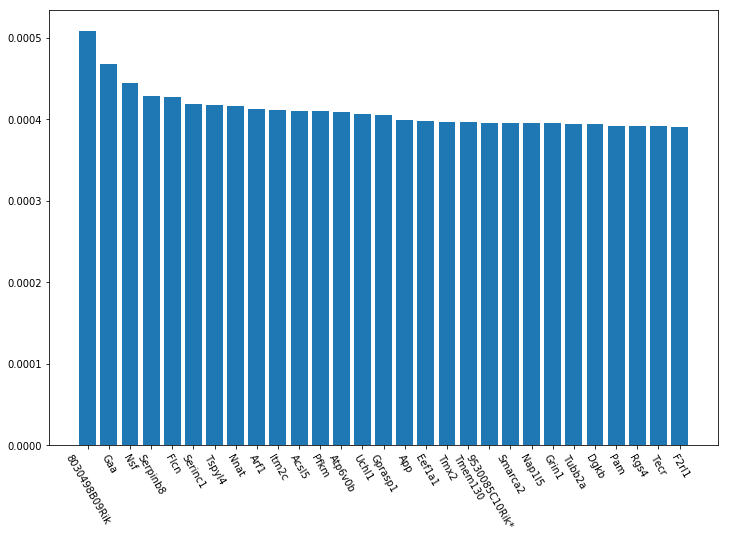

In [39]:
top_50_vals  = np.argsort(Components_mod[PV_dominated_atom,:])[::-1][0:30]
top_50_genes = [MesoPred.params['Gene Acronyms'][val] for val in top_50_vals]
#pk.dump([top_50_genes, Components_mod, PV_dominated_atom, top_50_vals], open('paper1_figures/elements_for_PV_module_after.pkl','wb'))

#[top_50_genes, Components_mod, PV_dominated_atom, top_50_vals] = pk.load(open('paper1_figures/elements_for_PV_module_after.pkl','rb'))
plt.figure(figsize = (12,8))
plt.bar(top_50_genes, Components_mod[PV_dominated_atom, top_50_vals])
plt.xticks(rotation = 300)
ax.xaxis.set_tick_params(labelsize = 12)
ax.yaxis.set_tick_params(labelsize = 16)
plt.savefig('paper1_figures/top_30_genes_after_module_{}.jpg'.format(PV_dominated_atom))
plt.savefig('paper1_figures/top_30_genes_after_module_{}.eps'.format(PV_dominated_atom))
plt.show()

### Step 5: Modified gradient visualization
Changes on the dominant gradient are being visually inspected as in step #3.

### Step 6: Predicted Projections

Let's assume that Bella is interested in predicted projection patterns coming from layer 6 corticothalamic cell types.
There are two approaches to it.   
The first approach is to utilze the CCP tool with the PredictProjections function which will predict the desired projection patterns based on altered gene expression patterns tested on the CCP predictive models. The outcome will be a matrix consisting of   target brain areas and a set source brain areas corresponding to injection locations of measured tracing experiments.     
The second approach is to take the output of the first approach and apply a computational modeling approach (GetLayerResolvedArray function) that was developed as part of the Allen Institute's mouse connectivity models toolbox (see more on Overview). The outcome of this approach is a kernel-regression based smoothened connectivity matrix between regionalized source and brain areas irregardless of the actual injection locations, which can simplify latter meta-analytic and visualization proceedures.

Let's start with the first approach. The MesoconnectomePredictor tool is being called for predicting projections between brain areas based on the modified gene expression (PredictProjections function). 

In [12]:
profile_of_interest = 'L6 CT'
ProjectionMat, exportFile, ProjectionDict = MesoPred.PredictProjections(GeneExp_mod2, 
                                                                        layer_profile = profile_of_interest)
print ProjectionMat                                                        

                 CP   SSp-bfd  SSp-bfd 2      VISa        PL      VISp  \
TMv        0.019837  0.045300   0.010303  0.011336  0.047271  0.048204   
SSp-m6b    0.089270  0.052180   0.002500  0.003868  0.180989  0.019752   
PSV        0.036408  0.038178   0.002562  0.005254  0.037475  0.028760   
SSp-tr6a   0.063013  0.243185   0.005686  0.006960  0.080382  0.098221   
IF         0.055915  0.007200  -0.000910  0.009648  0.019695 -0.000655   
PT         0.031695  0.185826   0.064393  0.120402  0.086053  0.180515   
SCiw       0.042711  0.114998   0.002365  0.004571  0.015121  0.056126   
IG         0.021604  0.089013   0.024949  0.038938  0.164999  0.078266   
ENTl2      0.069386  0.003636   0.001394  0.000577  0.111967  0.003311   
AAA        0.147827  0.052228   0.005089  0.013032  0.115722  0.003215   
SCdg       0.046212  0.102262   0.000940  0.002428  0.013067  0.043588   
IGL        0.166118  0.264086   0.013175  0.030873  0.012639  0.206985   
ENTl6a     0.017630  0.008861   0.0010

### Step 7: Find a predicted projection of interest   
Let's assume that Bella is interested at a predicted projection pattern from an area at which PV is a strong predictive component according to our predictive models.

In [13]:
sel_tracer = {'val': [], 'id': [], 'key': []};
for key in ClfResults_ridge.keys():
    if 'L6' in MesoPred.ConDict[key]['layer'][0] and 'CT' in MesoPred.ConDict[key]['cell-type'][0]:
        sel_tracer['val'].append(np.max(ClfResults_ridge[key]['final model'].coef_[:,PV_index]))
        sel_tracer['id'].append(np.argmax(ClfResults_ridge[key]['final model'].coef_[:,PV_index]))
        sel_tracer['key'].append(key)
      
selected_cre    = sel_tracer['key'][np.argmax(sel_tracer['val'])]
selected_index  = sel_tracer['id'][np.argmax(sel_tracer['val'])]
selected_source = MesoPred.ConDict[selected_cre]['structure-abbrev'][selected_index]
print selected_cre, selected_source

Syt6-Cre_KI148 SSp-ll


The source location for which PV is a strong predictive component for a corresponding tracer with L6 CT profile is SSp-ll

In [14]:
sspPattern_pred   = ProjectionDict[selected_cre]['y_preds'][:, selected_index]
sspPattern_actual = ClfResults_ridge[selected_cre]['y_actual'][:,selected_index]
print sspPattern_actual

[  4.33408989e-02   2.14031723e-02   6.93026613e-03   1.18478769e-01
  -6.14764240e-10   2.76879820e-02   1.25603006e-01   1.16098643e-01
  -6.14764240e-10   1.26924304e-02   7.53161840e-02   6.26343613e-03
  -6.14764240e-10   3.50999795e-03  -6.14764240e-10   1.03701563e-01
  -6.14764240e-10  -6.14764240e-10   4.94437019e-03  -6.14764240e-10
   9.57003142e-03   2.81830502e-02   1.25619102e-02   7.21580094e-03
  -6.14764240e-10  -6.14764240e-10  -6.14764240e-10   7.23372029e-02
   1.10095562e-01   8.79965817e-03   2.93794724e-02   6.20226374e-02
   1.03535263e-01  -6.14764240e-10  -6.14764240e-10   5.43041099e-01
  -6.14764240e-10   1.03637445e-03   1.13668966e-01  -6.14764240e-10
  -6.14764240e-10  -6.14764240e-10   1.15207996e-02   1.10525891e-01
  -6.14764240e-10  -6.14764240e-10   3.21421083e-03  -6.14764240e-10
  -6.14764240e-10   5.38647323e-02  -6.14764240e-10  -6.14764240e-10
   5.05340548e-02   1.30026849e-01   1.71506998e-01   6.51472282e-02
  -6.14764240e-10   2.69828294e-03

### Step 8: Visualize the projection  
Cortical flatmap and brain slice visualization for the measured and predicted projection pattern of interest (??).

Before Prediction

After prediction

In [ ]:
BP_10_new = PL.BrainPlotter(resolution = 10)
BP_25_new = PL.BrainPlotter(resolution = 25)

BP_10_new.fit(projection = np.asarray(sspPattern_pred), chosen_indices = MesoPred.params['remaining_indices'])
BP_25_new.fit(projection = np.asarray(sspPattern_pred), chosen_indices = MesoPred.params['remaining_indices'])
#pk.dump([BP_25_new, BP_10_new], open('paper1_figures/Syt6_SSp_Volumetric_pred.pkl','wb'))

#[selected_cre,selected_index] = pk.load(open('paper1_figures/Syt6_SSp_info.pkl','rb'))
#[BP_25_new, BP_10_new] = pk.load(open('paper1_figures/Syt6_SSp_Volumetric_pred.pkl','rb'))
BP_25_new.plot_slice(savefile = 'paper1_figures/predicted_patterns_slice_{}_{}.jpg'.format(selected_cre,selected_index))
BP_10_new.plot_flatmap(savefile = 'paper1_figures/predicted_patterns_flatmap_{}_{}.jpg'.format(selected_cre,selected_index))

### Step 10: Alternatively construct a regional 2D connectivity matrix based on the profile of interest (L6 CT)

Let's continue with the second approach as mentioned in step 6

In [34]:
creFilter = [key for key,value in MesoPred.ConDict.items() 
             if value['layer'][0] in profile_of_interest and value['cell-type'][0] in profile_of_interest]
layer_resolved_array, model_meta = MesoPred.GetLayerResolvedArray(mode = 'unionized', 
                                                                  creFilter = creFilter,
                                                                  InputDict = ProjectionDict, 
                                                                  rem_ind = MesoPred.params['remaining_indices'],
                                                                  resolution = 200)

Current analyzed cre lines are: L6 CT -> ['Ntsr1-Cre_GN220', 'Syt6-Cre_KI148']
